# Анализ пространственных данных. Домашнее задание №1

Данные для выполнения заданий можно найти [здесь](https://yadi.sk/d/xBemeb0ODlhCAQ?w=1)

Дедлайн: __20 октября 2020 г. 09:00__

ФИО: `Жилин Глеб Владимирович`

Группа: `MADE-DS-32`

## Задание №1. Reading coordinates from a file and creating a geometries. 4 балла.

One of the "classical" problems in GIS is the situation where you have a set of coordinates in a file and you need to get them into a map (or into a GIS-software). Dataset `travelTimes_2015_Helsinki.txt` consist of travel times between specific locations in Helsinki Region.

1. Read the data into memory.
2. Read 4 columns `from_x`, `from_y`, `to_x`, `to_y` from the data.
3. Create two lists called __orig_points__ and __dest_points__
4. Iterate over the rows of your numpy array and add Shapely Point -objects into the __orig_points__ -list and __dest_point__ -list representing the origin locations and destination locations accordingly.

`from_x`: x-coordinate of the __origin__ location (longitude)

`from_y`: y-coordinate of the __origin__ location (latitude)

`to_x`: x-coordinate of the __destination__ location (longitude)

`to_y`: y-coordinate of the __destination__ location (latitude)

In [14]:
import pandas as pd
import numpy as np
from shapely.geometry import Point

table = pd.read_csv('travelTimes_2015_Helsinki.txt', delimiter=';')
table = table[['from_x', 'from_y', 'to_x', 'to_y']]

orig_points, dest_points = [], []

for idx, row in table.iterrows():
    orig_points.append(Point(row['from_x'], row['from_y']))
    dest_points.append(Point(row['to_x'], row['to_y']))

## Задание №2. Creating LineStrings that represent the movements. 6 баллов.

Please use data from previous task:

1. Create a list called `lines`
2. Iterate over the __orig_points__ and __dest_points__ lists and create a Shapely _LineString_ -object between the origin and destination point
3. Add that line into the `lines` -list.
4. Find out what is the average (Euclidian) distance of all the origin-destination _LineStrings_ that we just created, and print it out.

In [15]:
from shapely.geometry import LineString

lines = [LineString([orig_p, dest_p]) for orig_p, dest_p in zip(orig_points, dest_points)]

av_dist = np.array([line.length for line in lines]).mean()

print(av_dist)

0.2150222482322721


## Задание №3. Points to map. 4 балла.

Aim is to plot a set of x and y coordinates that we should read from a `some_posts.csv`. The data has 81379 rows and consists of locations and times of social media posts inside Kruger national park in South Africa.

1. Read the data into memory.
2. Create an empty column called `geometry` where you will store shapely _Point_ objects
3. Iterate over the rows of the DataFrame (__x__ and __y__ -coordinates) and insert _Point_ objects into column `geometry`
4. Convert that DataFrame into a GeoDataFrame
5. Update the CRS for coordinate system as WGS84 (i.e. epsg code: 4326)
6. Save the data into a Shapefile called `Kruger_posts.shp`
7. Create a simple map of those points using .plot() -funtion

`lat`: y-coordinate of the post

`lon`: x-coordinate of the post

`timestamp`: Time when the post was uploaded

`userid`: userid

In [16]:
import geopandas as gpd
from matplotlib import pyplot as plt

In [17]:
table = pd.read_csv('some_posts.txt')

In [18]:
table['geometry'] = pd.Series(dtype=object) 

In [19]:
for idx, row in table.iterrows():
    table.at[idx, 'geometry'] = Point(row['lat'], row['lon'])

In [20]:
gtable = gpd.GeoDataFrame(table)

In [21]:
gtable = gtable.set_crs(epsg=4326)

In [22]:
gtable.to_file('Kruger_posts.shp')

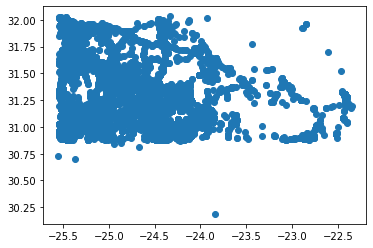

In [23]:
gtable.plot()
plt.show()

## Задание №4. Movements of individual user. 6 баллов.

Please use data from previous task:

1. Group the data by `userid`
2. Create an empty GeoDataFrame
3. For each user:
   - sort the rows by `timestamp`
   - create _LineString_ objects based on the points
   - add the `geometry` and the `userid` into the GeoDataFrame you created in the last step
4. Determine the CRS of your GeoDataFrame to WGS84 (epsg code: 4326)
5. Save the movements of each user into a separate Shapefile
   - Name the output Shapefile based on the `userid` number

In [35]:
import fiona

In [48]:
from shapely.geometry import mapping
import os

In [52]:
dir_name = 'user_movements'

In [55]:
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [25]:
mov_table = gpd.GeoDataFrame()
for userid, t in gtable.groupby('userid'):
    t = t.sort_values('timestamp')
    try:
        line_str = LineString(t['geometry'].values)
    except:
        continue
    mov_table = mov_table.append(gpd.GeoDataFrame({'userid': [userid], 'geometry': [line_str]}),
                                    ignore_index=True)

In [56]:
for idx, row in mov_table.iterrows():
    with fiona.open(os.path.join(dir_name, f'{row["userid"]}.shp'), 'w',
                    driver='ESRI Shapefile',
                    schema={'geometry': 'LineString'}) as fp:
        fp.write({'geometry': mapping(row['geometry'])})

## Задание №5. Join accessibility datasets into a grid and visualize them by using a classifier. 4 балла.

A dataset from `dataE4.zip` includes 7 text files containing data about accessibility in Helsinki Region and a Shapefile that contains a Polygon grid that can be used to visualize and analyze the data spatially. The datasets are:

 - `travel_times_to_[XXXXXXX]_[NAME-OF-THE-CENTER].txt` including travel times and road network distances to specific shopping center
 - `MetropAccess_YKR_grid_EurefFIN.shp` including the Polygon grid with __YKR_ID__ column that can be used to join the grid with the accessibility data
 
Find out more about the data [here](https://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix-2015/)

1. Read those travel_time data files (one by one) with Pandas and select only following columns from them:

 - `pt_r_tt`
 - `car_r_t`
 - `from_id`
 - `to_id`


2. Visualize the classified travel times (Public transport AND Car) of at least one of the shopping centers using any classification method (see [PySAL](https://pysal.org/) for more details upon classification methods). You need to classify the data into a new column in your GeoDataFrame.

In [226]:
dir_name = 'dataE4'
fnames = os.listdir(dir_name)
fnames = list(filter(lambda x: x.split('.')[-1]=='txt', fnames))
shop_names = list(map(lambda x: '_'.join(x.split('.')[-2].split('_')[3:]), fnames))
shop_names = np.array(shop_names)

In [144]:
tables = []
for fname in fnames:
    table = pd.read_csv(os.path.join(dir_name, fname), delimiter=';')
    table = table[['pt_r_tt', 'car_r_t', 'from_id', 'to_id']]
    table = table[table['to_id'] >= 0].sort_values('from_id')
    tables.append(table)

In [209]:
ids = tables[0]['from_id'].values
for table in tables:
    assert((ids == table['from_id']).all())

In [222]:
pt_times = np.stack([table['pt_r_tt'].values for table in tables], axis=1)
pt_times[pt_times <= 0] = np.iinfo(pt_times.dtype).max
car_times = np.stack([table['car_r_t'].values for table in tables], axis=1)
car_times[car_times <= 0] = np.iinfo(car_times.dtype).max

In [213]:
pt_closest = pt_times.argmin(axis=1)
car_closest = car_times.argmin(axis=1)

In [214]:
grid = gpd.read_file(os.path.join(dir_name, 'MetropAccess_YKR_grid_EurefFIN.shp'))

In [215]:
grid = grid[grid['YKR_ID'].isin(ids)]

In [227]:
grid['pt_closest'] = shop_names[pt_closest]
grid['car_closest'] = shop_names[car_closest]

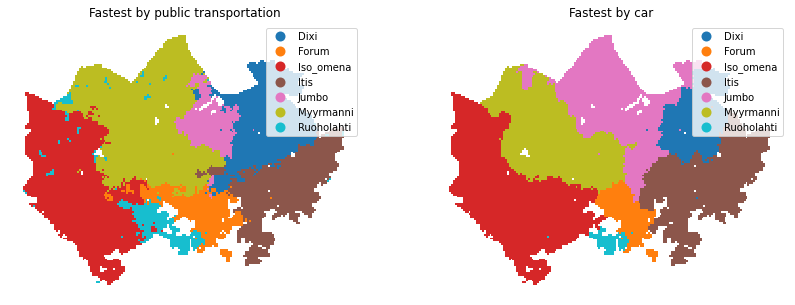

In [244]:
fig, ax = plt.subplots(1,2,figsize=(14,6))
ax[0].set(title='Fastest by public transportation')
ax[0].set_axis_off()
grid.plot(column='pt_closest', categorical=True, legend=True, ax=ax[0])
ax[1].set(title='Fastest by car')
ax[1].set_axis_off()
grid.plot(column='car_closest', categorical=True, legend=True, ax=ax[1])
plt.show()

Have unknowingly done the next task before seeing it...

So another visualization:

In [248]:
faster_by_pt = pt_times.min(axis=1) < car_times.min(axis=1)

In [251]:
grid['faster_by_pt'] = faster_by_pt

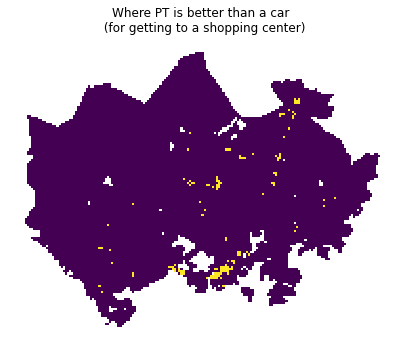

In [258]:
fig, ax = plt.subplots(figsize=(7,6))
ax.set(title='Where PT is better than a car \n (for getting to a shopping center)')
ax.set_axis_off()
grid.plot(column=faster_by_pt, ax=ax)
plt.show()

## Задание №6. Calculate and visualize the dominance areas of shopping centers. 6 баллов.

Please use data from previous task. The aim is to define the dominance area for each of those shopping centers based on travel time:

1. Iterate over the accessibility files one by one
2. Rename the travel time columns so that they can be identified
   - you can include e.g. the `to_id` number as part of the column name (then the column name could be e.g. "pt_r_tt_5987221")
3. Join those columns into `MetropAccess_YKR_grid_EurefFIN.shp` where __YKR_ID__ in the grid corresponds to `from_id` in the travel time data file. At the end you should have a GeoDataFrame with different columns show the travel times to different shopping centers.
4. For each row find out the __minimum__ value of __all__ `pt_r_tt_XXXXXX` columns and insert that value into a new column called `min_time_pt`. You can now also parse the `to_id` value from the column name (i.e. parse the last number-series from the column text) that had the minimum travel time value and insert that value as a number into a column called `dominant_service`. In this, way are able to determine the "closest" shopping center for each grid cell and visualize it either by travel times or by using the __YKR_ID__ number of the shopping center (i.e. that number series that was used in column name).
5. Visualize the travel times of our `min_time_pt` column using any classifier.
6. Visualize also the values in `dominant_service` column (no need to use any specific classifier). Notice that the value should be a number. If it is still as text, you need to convert it first.

In [259]:
dir_name = 'dataE4'
fnames = os.listdir(dir_name)
fnames = list(filter(lambda x: x.split('.')[-1]=='txt', fnames))
shop_names = list(map(lambda x: '_'.join(x.split('.')[-2].split('_')[3:]), fnames))
shop_names = np.array(shop_names)

In [268]:
grid = gpd.read_file(os.path.join(dir_name, 'MetropAccess_YKR_grid_EurefFIN.shp'))

In [284]:
for fname in fnames:
    table = pd.read_csv(os.path.join(dir_name, fname), delimiter=';')
    to_id = str(table['to_id'][0])
    table = table[['pt_r_tt', 'car_r_t', 'from_id']]
    table = table[np.logical_and(table['pt_r_tt'] >= 0, table['car_r_t'] >= 0)]
    table.rename(columns={
        'pt_r_tt': 'pt_r_tt' + '_' + to_id,
        'car_r_t': 'car_r_t' + '_' + to_id,
        },inplace=True)
    grid = pd.merge(grid, table, left_on='YKR_ID', right_on='from_id')

In [293]:
pt_colnames = list(filter(lambda x: x[:3] == 'pt_', grid.columns))
car_colnames = list(filter(lambda x: x[:3] == 'pt_', grid.columns))

In [323]:
pt_best_times = grid[pt_colnames].min(axis=1)
pt_best_ids = grid[pt_colnames].values.argmin(axis=1)
pt_best_ids = np.vectorize(lambda x: int(x.split('_')[-1]))(np.array(pt_colnames)[pt_best_ids])

car_best_times = grid[car_colnames].min(axis=1)
car_best_ids = grid[car_colnames].values.argmin(axis=1)
car_best_ids = np.vectorize(lambda x: int(x.split('_')[-1]))(np.array(car_colnames)[car_best_ids])

In [335]:
sorted_times = np.sort(pt_best_times.values)
top_10p = sorted_times[-len(sorted_times)//10]
bottom_10p = sorted_times[len(sorted_times)//10]

def availability(t):
    if t <= bottom_10p:
        return 'good'
    if t >= top_10p:
        return 'bad'
    else:
        return 'ok'

avail = np.array([availability(t) for t in pt_best_times.values])
grid['availability'] = avail

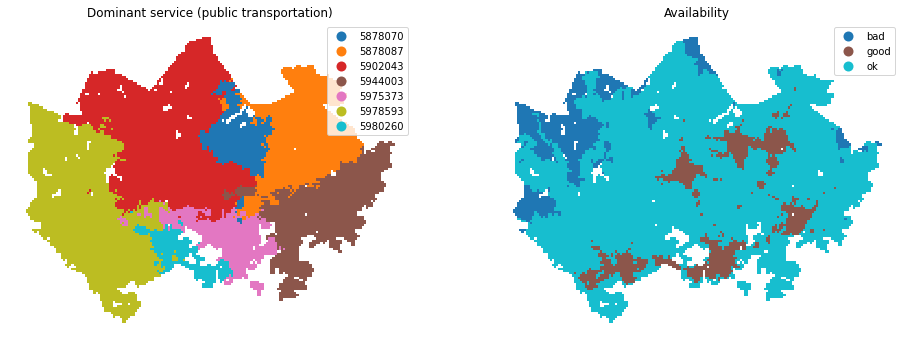

In [342]:
fig, axes = plt.subplots(1, 2, figsize=(16,7))
axes[0].set_axis_off()
axes[0].set(title='Dominant service (public transportation)')
grid.plot(column='dominant_service', categorical=True, legend=True, ax=axes[0])
axes[1].set_axis_off()
axes[1].set(title='Availability')
grid.plot(column='availability', categorical=True, legend=True, ax=axes[1])
plt.show()